# **AMAZON FOOD REVIEWS USING KNN ALGORITHM**
Packages installed to use data from kaggle 

Installing the necessary packages

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohitbohra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

The data has been duplicate and invalid data is being removec and the data is reduced to 69.25%

---



In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

The total data size is 364171 rows and 10 columns of data. 

1.   307061 is the total positive reviews
2.   57110 is the total negative reviews


## Data cleaning, stemming, Lemmetization

In [10]:
#stemming, stop word removal and lemmatization
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'ain', 'you', "didn't", 'for', 's', 'why', 'mightn', 'not', 'above', 'who', 'through', "isn't", 'down', 'more', 'my', 'nor', 'than', 'or', 'her', 'didn', 'ma', 'me', "needn't", 'yourself', 'theirs', "that'll", 'again', "you'll", 'too', "hadn't", "mightn't", 'm', 'how', "mustn't", 'she', 'in', 'over', 'here', 'because', 'and', 're', 'from', 'am', 'be', 'haven', 'this', 'your', 'wasn', 'hasn', 'into', 'wouldn', 'at', 'we', 'being', 'll', "couldn't", 'so', 'have', 'isn', 'will', 'is', 't', 'their', 'but', 'what', 'don', 'a', 'was', "hasn't", 'its', 'which', 'just', 've', 'weren', 'won', "shouldn't", 'other', 'then', 'no', "you've", 'yourselves', 'these', 'needn', 'does', 'below', 'own', 'those', 'each', 'himself', "wouldn't", 'until', 'his', 'to', 'now', 'themselves', "weren't", 'with', 'where', 'yours', 'they', 'aren', 'has', "aren't", 'few', 'very', 'i', 'him', "shan't", 'y', 'o', 'doesn', 'before', 'our', 'mustn', 'ourselves', 'up', 'all', 'on', 'd', 'ours', 'as', 'after', 'there', 'b

In [26]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [ ]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [22]:
final.to_pickle("./amazon.pkl")

In [23]:
final['Score'].value_counts()

1    50447
0     9553
Name: Score, dtype: int64

In [24]:
# read data from pickle file from previous stage
data = pd.read_pickle("./amazon.pkl")

In [25]:
data.shape

(60000, 12)

In [19]:
final['Time'] = pd.to_datetime(final['Time'])
# Random sampling
final = final.take(np.random.permutation(len(final))[:100000])
final=final.sort_values(by='Time')

In [21]:
final.shape

(60000, 12)

## **BAG OF WORDS**

In [74]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final_brute['CleanedText'].values,final_brute['Score'].values, test_size = 0.3, shuffle = False)

In [75]:
print("x_train size",x_train.shape)
print("y_train size",y_train.shape)
print("x_test size",x_test.shape)
print("y_test size",y_test.shape)
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))


x_train size (42000,)
y_train size (42000,)
x_test size (18000,)
y_test size (18000,)
Counts of Positive reviews 35818
Counts of Negative reviews 6182


In [76]:
#BAG OF WORDS
# Fuction to compute k value
def k_classifier_brute(x_train, y_train):
    # creating odd list of K for KNN
    myList = list(range(5,50,4))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute", n_jobs=-1)
        scores = cross_val_score(knn, x_train, y_train, cv=3, scoring='f1_micro',n_jobs=-1,verbose=1)
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(max(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Prediction vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Predictions')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k

In [77]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
x_train = bow.fit_transform(x_train)
x_train

<42000x25121 sparse matrix of type '<class 'numpy.int64'>'
	with 1315343 stored elements in Compressed Sparse Row format>

In [78]:
# Test Vectorizor
x_test = bow.transform(x_test)

In [79]:
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))

Counts of Positive reviews 35818
Counts of Negative reviews 6182


In [80]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

ros=RandomOverSampler(random_state=42)
x_train,y_train=ros.fit_resample(x_train,y_train)
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))

Counts of Positive reviews 35818
Counts of Negative reviews 35818


In [81]:
print("Counts of Positive reviews",sum(y_test==1))
print("Counts of Negative reviews",sum(y_test==0))

Counts of Positive reviews 14869
Counts of Negative reviews 3131


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3


The optimal number of neighbors is 5.


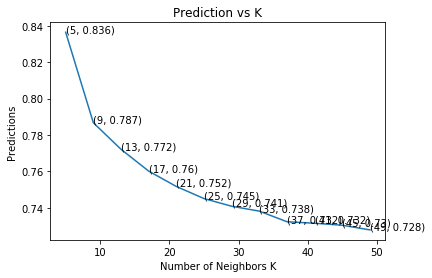

the misclassification error for each k value is :  [0.836 0.787 0.772 0.76  0.752 0.745 0.741 0.738 0.732 0.732 0.73  0.728]


5

In [82]:
# To choose optimal_k using brute force algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


optimal_k_bow = k_classifier_brute(x_train, y_train)
optimal_k_bow

In [83]:
print(optimal_k_bow)

5


In [84]:
 # instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [85]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy on test set: 74.544%
Precision on test set: 0.880
Recall on test set: 0.801
F1-Score on test set: 0.839


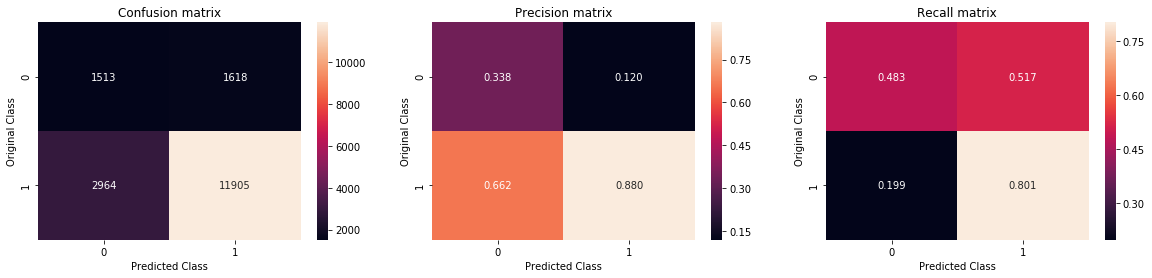

In [86]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**

1.   Splitting of data into Train and Test, where 70% of the data is for training the model and 30% of the data to check how good the model is performing.

2.   We transform the data into Bag Of Words.

3.   In training data, we use upsampling to make the data points of both classes equal. 

4.  We find the optimal k value using Brute algorithm in K-Nearest Neighbour method algorithm.

Accuracy on test set: 71.994%

Precision on test set: 0.873

Recall on test set: 0.774

F1-Score on test set: 0.820


*   Accuracy of prediction for Positive class is very good but model doesn't perform well for negative class. 

*   Prediction precision is very high for negative class and low for positive class.


*   Recall is high for positive class and low for negative class.

Using Bag of Words featurization with 60000 data, the model is bias towards positive class but precision for negative class is high. 






#### kd_tree 

In [87]:
final['Time'] = pd.to_datetime(final['Time'])
# Random sampling
final_kd_tree = final.take(np.random.permutation(len(final))[:25000])
final_kd_tree=final_kd_tree.sort_values(by='Time')

In [88]:
kd_tree_final.shape

(5000, 12)

In [89]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(kd_tree_final['CleanedText'].values,kd_tree_final['Score'].values, test_size = 0.3, shuffle = False)

In [90]:
print("x_train size",x_train.shape)
print("y_train size",y_train.shape)
print("x_test size",x_test.shape)
print("y_test size",y_test.shape)
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))

x_train size (3500,)
y_train size (3500,)
x_test size (1500,)
y_test size (1500,)
Counts of Positive reviews 2979
Counts of Negative reviews 521


ValueError: could not convert string to float: 'usual pleas recommend consum amazon one mile your regular serious colombian coffe drinker decaf instant would never go great disappoint gave bag away neighbor use drink stale instant took back day manag psychiatr facil coffe wasnt even instant someth horribl call postum think didnt even resembl coffe heck would rather drank note old cardboard stuff tri everyth even mix regular colombian advic dont wast money purchas papaya enzym tablet tum instead bulk nexium dont near puroroast buy real lead coffe instead'

In [45]:
#BAG OF WORDS
# Fuction to compute k value
def k_classifier_kd_tree(x_train, y_train):
    # creating odd list of K for KNN
    myList = list(range(5,50,4))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree", n_jobs=-1)
        scores = cross_val_score(knn, x_train, y_train, cv=3, scoring='f1_micro',n_jobs=-1,verbose=1)
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(max(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Prediction vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Predictions')
    plt.show()

    print("Prediction for each k value is : ", np.round(MSE,3))
    return optimal_k

In [46]:
#To choose optimal_k using kd_tree algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


optimal_k_bow = k_classifier_kd_tree(x_train, y_train)
optimal_k_bow

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [41]:
 # instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

Accuracy on test set: 71.994%
Precision on test set: 0.873
Recall on test set: 0.774
F1-Score on test set: 0.820


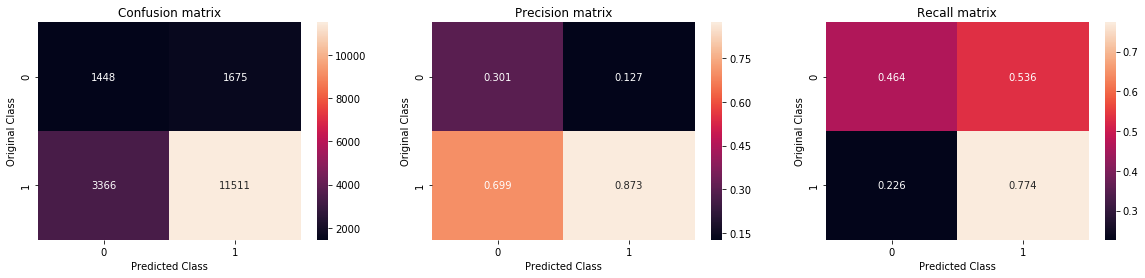

In [42]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**

We find the optimal k value using kd tree algorithm in K-Nearest Neighbour method algorithm.

Accuracy on test set: 71.994%

Precision on test set: 0.873

Recall on test set: 0.774

F1-Score on test set: 0.820

*   Accuracy of prediction for Positive class is very good but model doesn't perform well for negative class. 

*   Prediction precision is very high for negative class and low for positive class.

*   Recall is high for positive class and low for negative class.

Using Bag of Words featurization with 60000 data, the model is bias towards positive class but precision for negative class is high. 




## **TF-IDF**

In [0]:
#TF-IDF
from sklearn.model_selection import train_test_split

# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

In [47]:
print("x_train size",x_train.shape)
print("y_train size",y_train.shape)
print("x_test size",x_test.shape)
print("y_test size",y_test.shape)
print(sum(y_train==1))
print(sum(y_train==0))

x_train size (42000,)
y_train size (42000,)
x_test size (18000,)
y_test size (18000,)
21993
20007


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=20000) 
x_train = tfidf.fit_transform(x_train)
x_train = preprocessing.normalize(x_train)

x_test = tfidf.transform(x_test)
x_test = preprocessing.normalize(x_test)

print("Train Data Size: ",x_train.shape)
print("Test Data Size: ",x_test.shape)

Train Data Size:  (42000, 20000)
Test Data Size:  (18000, 20000)


In [49]:
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))

Counts of Positive reviews 21993
Counts of Negative reviews 20007


In [50]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

ros=RandomOverSampler(random_state=42)
x_train,y_train=ros.fit_resample(x_train,y_train)
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))

Counts of Positive reviews 21993
Counts of Negative reviews 21993



The optimal number of neighbors is 49.


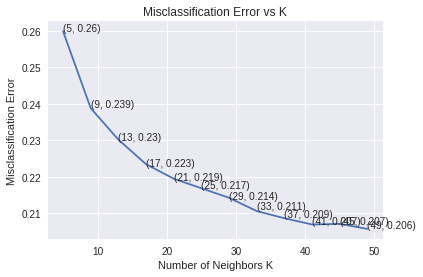

the misclassification error for each k value is :  [0.26  0.239 0.23  0.223 0.219 0.217 0.214 0.211 0.209 0.207 0.207 0.206]


49

In [51]:
#To choose optimal_k using brute force algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


optimal_k_bow = k_classifier_brute(x_train, y_train)
optimal_k_bow

In [0]:
 # instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [53]:
# evaluate accuracy on test data
y_pred = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %.3f%%' % (optimal_k_bow, y_pred))


The accuracy of the knn classifier for k = 49 is 79.072%


Accuracy on test set: 79.072%
Precision on test set: 0.729
Recall on test set: 0.842
F1-Score on test set: 0.782
-------------------- Confusion matrix --------------------


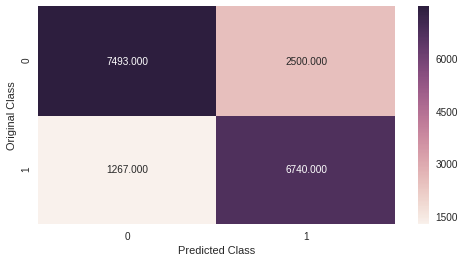

-------------------- Precision matrix (Columm Sum=1) --------------------


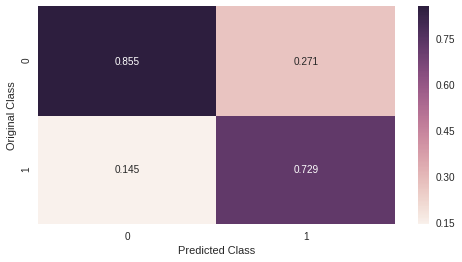

-------------------- Recall matrix (Row sum=1) --------------------


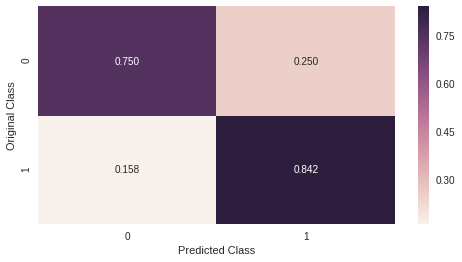

In [54]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**

1.   Splitting of data into Train and Test, where 70% of the data is for training the model and 30% of the data to check how good the model is performing.

2.   We transform the data into TF-IDF.

3.   In training data, we use upsampling to make the data points of both classes equal. 

4.  We find the optimal k value using Brute algorithm in K-Nearest Neighbour method algorithm.

Accuracy on test set: 79.07%

Precision on test set: 72.9%

Recall on test set: 84.2%

F1-Score on test set: 78.2%

*   Accuracy of prediction for Positive class and Negative class is very good.

*   Prediction precision is very high for negative class when compared to positive class.


*   Recall is high for positive class when compared to negative class.

Using TF-IDF featurization with 60000 data, the model works fairly well for both the classes.



The optimal number of neighbors is 49.


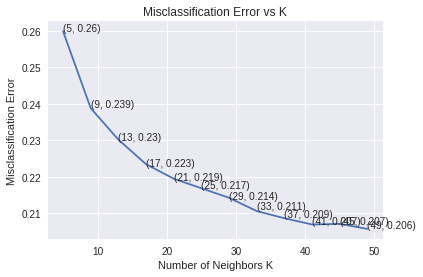

the misclassification error for each k value is :  [0.26  0.239 0.23  0.223 0.219 0.217 0.214 0.211 0.209 0.207 0.207 0.206]


49

In [55]:
#To choose optimal_k using kd_tree algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


optimal_k_bow = k_classifier_kd_tree(x_train, y_train)
optimal_k_bow

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [57]:
# evaluate accuracy on test data
y_pred = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %.3f%%' % (optimal_k_bow, y_pred))


The accuracy of the knn classifier for k = 49 is 79.072%


Accuracy on test set: 79.072%
Precision on test set: 0.729
Recall on test set: 0.842
F1-Score on test set: 0.782
-------------------- Confusion matrix --------------------


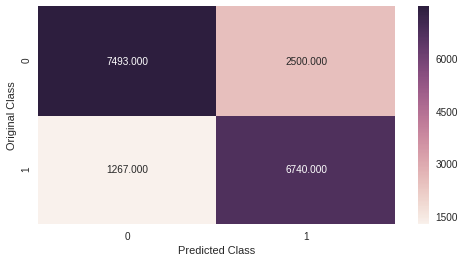

-------------------- Precision matrix (Columm Sum=1) --------------------


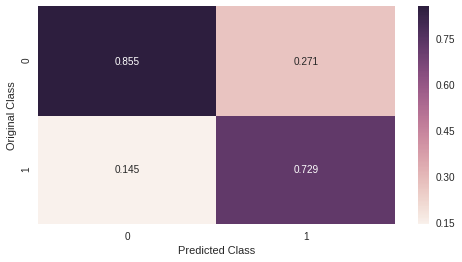

-------------------- Recall matrix (Row sum=1) --------------------


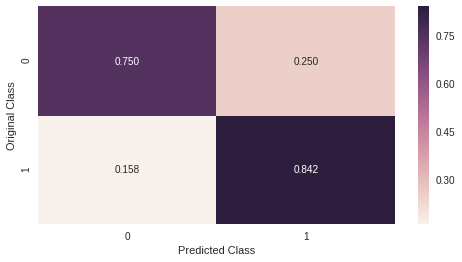

In [58]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**

 We find the optimal k value using kd-Tree algorithm in K-Nearest Neighbour method algorithm.

Accuracy on test set: 79.07%

Precision on test set: 72.9%

Recall on test set: 84.2%

F1-Score on test set: 78.2%

*   Accuracy of prediction for Positive class and Negative class is very good.

*   Prediction precision is very high for negative class when compared to positive class.


*   Recall is high for positive class when compared to negative class.

Using TF-IDF featurization with 60000 data, the model works fairly well for both the classes.


## **Word2Vec**

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())



In [60]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model = Word2Vec(list_of_sent,min_count=5,size=50, workers=4)



In [62]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])


number of words that occured minimum 5 times  10917
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach']


Taking the data and transforming it into Vectors using Word2Vector method

## **Average Word2Vec**

In [63]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

60000
50


In [0]:
#Average W2V
from sklearn.model_selection import train_test_split

# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(sent_vectors, final['Score'].values, test_size=0.3, shuffle=False)

In [65]:
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))

Counts of Positive reviews 21993
Counts of Negative reviews 20007


In [66]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

ros=RandomOverSampler(random_state=42)
x_train,y_train=ros.fit_resample(x_train,y_train)
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))

Counts of Positive reviews 21993
Counts of Negative reviews 21993



The optimal number of neighbors is 29.


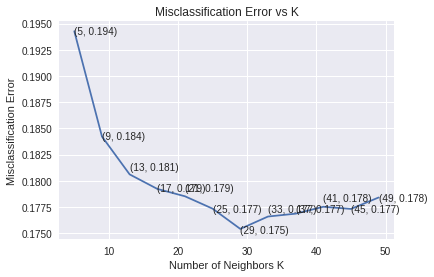

the misclassification error for each k value is :  [0.194 0.184 0.181 0.179 0.179 0.177 0.175 0.177 0.177 0.178 0.177 0.178]


29

In [67]:
#To choose optimal_k using brute force algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


optimal_k_bow = k_classifier_brute(x_train, y_train)
optimal_k_bow

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [69]:
# evaluate accuracy on test data
y_pred = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %.3f%%' % (optimal_k_bow, y_pred))


The accuracy of the knn classifier for k = 29 is 82.922%


Accuracy on test set: 82.922%
Precision on test set: 0.796
Recall on test set: 0.829
F1-Score on test set: 0.812
-------------------- Confusion matrix --------------------


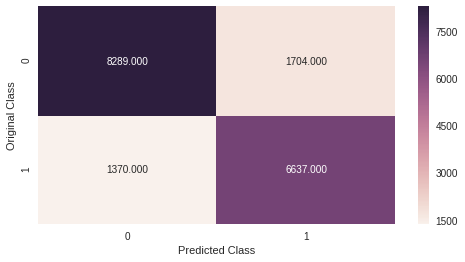

-------------------- Precision matrix (Columm Sum=1) --------------------


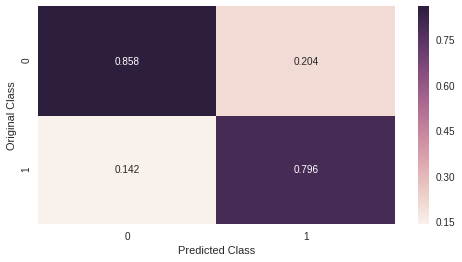

-------------------- Recall matrix (Row sum=1) --------------------


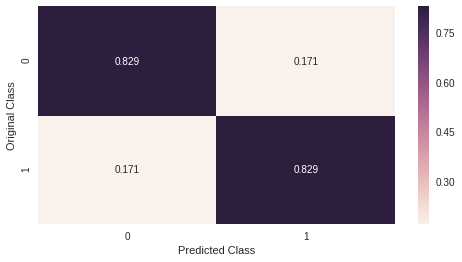

In [70]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**

1.   Splitting of data into Train and Test, where 70% of the data is for training the model and 30% of the data to check how good the model is performing.

2.   We transform the data using Average Word2Vec.

3.   In training data, we use upsampling to make the data points of both classes equal. 

4.  We find the optimal k value using Brute algorithm in K-Nearest Neighbour method algorithm.

Accuracy on test set: 82.92%

Precision on test set: 79.6%

Recall on test set: 82.9%

F1-Score on test set: 81.2%

*   Accuracy of prediction for Positive class and Negative class is very good but works work forNegative class.

*   Prediction precision is very high for negative class when compared to positive class.


*   Recall is high and equal for positive class and negative class.

Using Average Word2Vec featurization with 60000 data, the model works well for both the classes.
 



The optimal number of neighbors is 29.


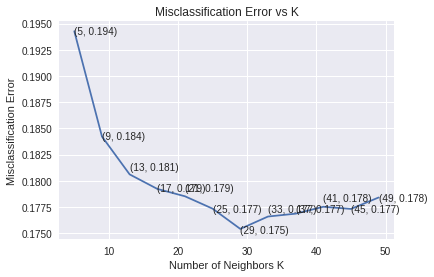

the misclassification error for each k value is :  [0.194 0.184 0.181 0.179 0.179 0.177 0.175 0.177 0.177 0.178 0.177 0.178]


29

In [71]:
#To choose optimal_k using kd_tree algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


optimal_k_bow = k_classifier_kd_tree(x_train, y_train)
optimal_k_bow

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [73]:
# evaluate accuracy on test data
y_pred = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %.3f%%' % (optimal_k_bow, y_pred))


The accuracy of the knn classifier for k = 29 is 82.922%


Accuracy on test set: 82.922%
Precision on test set: 0.796
Recall on test set: 0.829
F1-Score on test set: 0.812
-------------------- Confusion matrix --------------------


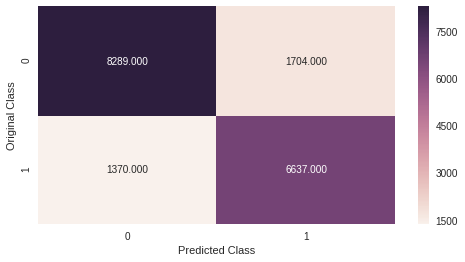

-------------------- Precision matrix (Columm Sum=1) --------------------


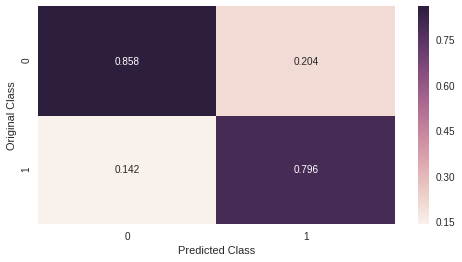

-------------------- Recall matrix (Row sum=1) --------------------


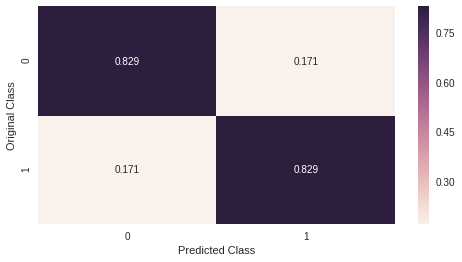

In [74]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**

We find the optimal k value using kd-Tree algorithm in K-Nearest Neighbour method algorithm.

Accuracy on test set: 82.92%

Precision on test set: 79.6%

Recall on test set: 82.9%

F1-Score on test set: 81.2%

*   Accuracy of prediction for Positive class and Negative class is very good but works work forNegative class.

*   Prediction precision is very high for negative class when compared to positive class.


*   Recall is high and equal for positive class and negative class.

Using Average Word2Vec featurization with 60000 data, the model works well for both the classes.
 

**TF-IDF weighted Word2Vec**

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [76]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 60000/60000 [02:10<00:00, 460.51it/s]


In [77]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))



60000
50


In [0]:
from sklearn.model_selection import train_test_split

# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(tfidf_sent_vectors, final['Score'].values, test_size=0.3, shuffle=False)


In [79]:
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))

Counts of Positive reviews 21993
Counts of Negative reviews 20007


In [80]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

ros=RandomOverSampler(random_state=42)
x_train,y_train=ros.fit_resample(x_train,y_train)
print("Counts of Positive reviews",sum(y_train==1))
print("Counts of Negative reviews",sum(y_train==0))

Counts of Positive reviews 21993
Counts of Negative reviews 21993



The optimal number of neighbors is 29.


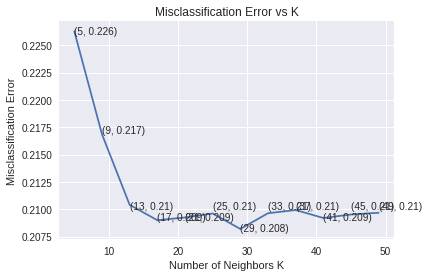

the misclassification error for each k value is :  [0.226 0.217 0.21  0.209 0.209 0.21  0.208 0.21  0.21  0.209 0.21  0.21 ]


29

In [81]:
#To choose optimal_k using brute force algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


optimal_k_bow = k_classifier_brute(x_train, y_train)
optimal_k_bow

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [83]:
# evaluate accuracy on test data
y_pred = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %.3f%%' % (optimal_k_bow, y_pred))


The accuracy of the knn classifier for k = 29 is 79.800%


Accuracy on test set: 79.800%
Precision on test set: 0.756
Recall on test set: 0.805
F1-Score on test set: 0.780
-------------------- Confusion matrix --------------------


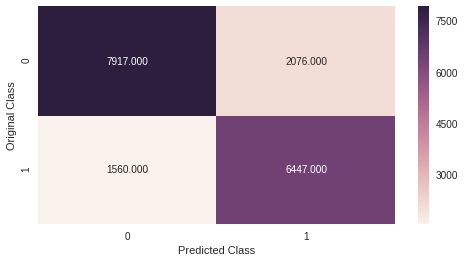

-------------------- Precision matrix (Columm Sum=1) --------------------


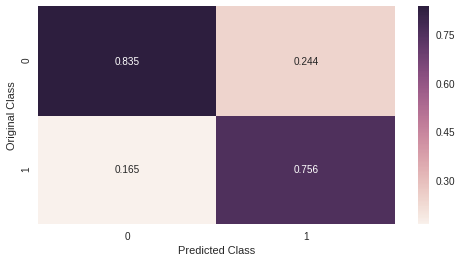

-------------------- Recall matrix (Row sum=1) --------------------


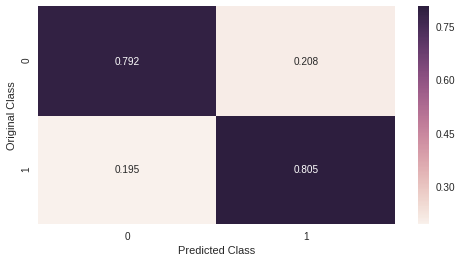

In [84]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
plot_confusion_matrix(y_test, pred)

**OBSERVATION**

1.   Splitting of data into Train and Test, where 70% of the data is for training the model and 30% of the data to check how good the model is performing.

2.   We transform the data using TF-IDF Weighted Word2Vec.

3.   In training data, we use upsampling to make the data points of both classes equal. 

4.  We find the optimal k value using Brute algorithm in K-Nearest Neighbour method algorithm.

Accuracy on test set: 79.80%

Precision on test set: 75.6%

Recall on test set: 80.5%

F1-Score on test set: 78%

*   Accuracy of prediction for Positive class and Negative class is very good but works well for Negative class when compared.

*   Prediction precision is very high for negative class when compared to positive class.


*   Recall is high for both positive class and negative class but a little higher for recall.

Using TF-IDF Weighted Word2Vec featurization with 60000 data, the model works well for both the classes.
 


The optimal number of neighbors is 29.


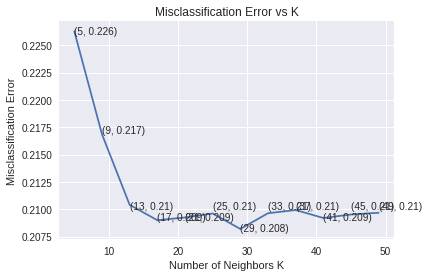

the misclassification error for each k value is :  [0.226 0.217 0.21  0.209 0.209 0.21  0.208 0.21  0.21  0.209 0.21  0.21 ]


29

In [85]:
#To choose optimal_k using brute force algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


optimal_k_bow = k_classifier_brute(x_train, y_train)
optimal_k_bow

In [0]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(x_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [87]:
# evaluate accuracy on test data
y_pred = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %.3f%%' % (optimal_k_bow, y_pred))


The accuracy of the knn classifier for k = 29 is 79.800%


Accuracy on test set: 79.800%
Precision on test set: 0.756
Recall on test set: 0.805
F1-Score on test set: 0.780
-------------------- Confusion matrix --------------------


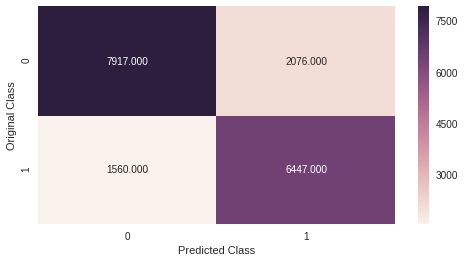

-------------------- Precision matrix (Columm Sum=1) --------------------


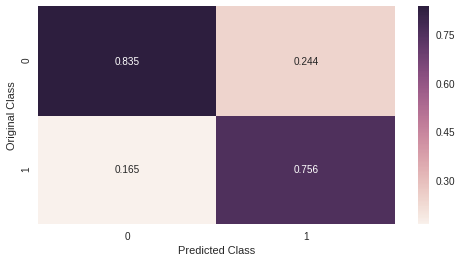

-------------------- Recall matrix (Row sum=1) --------------------


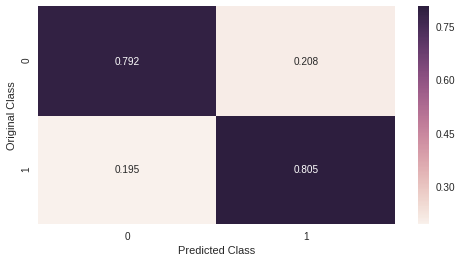

In [88]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
plot_confusion_matrix(y_test, pred)

## OBSERVATION

We find the optimal k value using Brute algorithm in K-Nearest Neighbour method algorithm.

Accuracy on test set: 79.8%

Precision on test set: 75.6%

Recall on test set: 80.5%

F1-Score on test set: 78%

F1-Score on test set: 78%

*   Accuracy of prediction for Positive class and Negative class is very good but works well for Negative class when compared.

*   Prediction precision is very high for negative class when compared to positive class.


*   Recall is high for both positive class and negative class but a little higher for positive class.

Using TF-IDF Weighted Word2Vec featurization with 60000 data, the model works well for both the classes.
 

# ![image](https://i.ibb.co/3mMMvzs/Screen-Shot-2018-12-13-at-2-36-48-PM.png)


---
# **FINAL OBSERVATION**







*   The accuracy for Amazon Food reviews using KNN algorithm : 

       1.   The best featurization technique is Average Word2Vec.
              It performs well because we take the semmantic meaning of the words 
              
       2.   The Worst featurization technique is Bag of Words.
              It performs badly because it takes single word as one feature and it is difficult to differentiate meaning from single word.

*    The precision and recall score is also good for Average Word2Vec featurization technique for both positive and Negative class.


The model can perform better if we choose more number of data to make our own word2vec model.

With increase in data, the machine will be trained well and output result may vary. 
